# Modelling Exercise: Stock Price Prediction
#### Student Name: Hiep Vo Dang
---

## Part 1: Introduction

This research project is focused on leveraging the capabilities of deep learning to predict stock closing prices, a task that has significant implications in the field of financial analysis and trading. The core objective is to develop and evaluate a variety of deep learning models, each designed to process and learn from historical stock market data. 

The data considered includes key stock market indicators: opening price (open), the highest price during the trading period (high), the lowest price (low), the closing price (close), and the trading volume (volume). These indicators are crucial as they reflect the market's behavior and sentiment towards a particular stock. The intention is not just to predict stock prices accurately but also to understand how different deep learning architectures perform in this domain. By analyzing historical data, these models aim to learn underlying patterns and trends in the stock market, which are not easily discernible through traditional statistical methods. 

The ultimate goal is to develop a tool that aids investors and financial analysts in making more informed decisions by providing them with more accurate predictions of stock market movements.

### 1.1. Stakeholders:

The primary stakeholders in this project are financial analysts and investors who actively engage in stock market trading. These stakeholders rely heavily on accurate and timely predictions of stock prices to make informed decisions about buying, selling, or holding stocks. By leveraging advanced deep learning models, they seek to gain a competitive edge in the market, optimizing their investment strategies for better returns.

### 1.2. Key problems:

The core problem for these stakeholders is the uncertainty and volatility inherent in stock market movements. Predicting stock prices is notoriously challenging due to the diversity of factors influencing the market, including economic indicators, company performance, and geopolitical events. Traditional methods of stock price prediction, which often rely on fundamental and technical analysis, may not adequately capture the complex, nonlinear patterns present in stock market data. Therefore, the stakeholders are in need of more sophisticated and accurate predictive models that can analyze historical stock data to forecast future price movements, thereby enabling more informed and strategic investment decisions.

### 1.3. Dataset:

The dataset for this project is obtained from Alpha Vantage, a popular provider of APIs for historical and real-time data on stocks, forex, and cryptocurrencies. Alpha Vantage offers a comprehensive suite of APIs that allow for easy access to a wide range of financial data, which is crucial for building robust predictive models in our project. The specific dataset used here includes historical data points such as open, high, low, close, and volume of stocks. For more detailed information on the dataset and how to access it, the Alpha Vantage API documentation can be consulted at https://www.alphavantage.co/documentation/. This resource provides guidelines on how to call the API to retrieve the necessary data for model training and validation.

## Part 2: Data Preparation

### 2.1. Planning:

The dataset for this project is sourced from Alpha Vantage through their private APIs. In this phase of the project, the API calling method is deliberately excluded from the code to facilitate reproducibility. Instead, the obtained data is stored in a CSV file format. This approach ensures that the data remains consistent and easily accessible for further analysis. The saved CSV file contains all the necessary data, which is then used for comprehensive analysis and as input for the predictive models. This method simplifies the data handling process and ensures that the focus remains on model development and evaluation rather than data retrieval complexities.

In the next stage of the project, which is planned as my final presentation (not this assignment), an ETL process will be developed. This process will involve calling the APIs and managing the creation of database schemas. The data obtained will then be transformed and loaded into the database. This ETL pipeline is designed to streamline the MLOps process. The project will then move towards a more automated and seamless operation, facilitating easier and more effective deployment of the machine learning models.

### 2.2. Data Transformation & Feature Engineering:

In this project, the focus is on five key features: open, high, low, close, and volume. By applying the log return transformation to these features, we aim to normalize the data and mitigate the effects of right-skewness and non-normality inherent in raw stock price data. This transformation is essential in preparing the data for deep learning models, enabling them to capture and learn from the nuanced movements and trends in stock prices more effectively.

Stock price data often exhibits certain distributional characteristics that are critical to understand for effective modeling. Common stock prices are typically right-skewed and bounded above 0, adhering to a lognormal distribution. This skewness arises because stock prices cannot fall below zero, resulting in a distribution that is bounded below and unbounded above, thus creating a rightward skew.

To address this, feature engineering plays a pivotal role, particularly through the transformation of stock prices into log returns. This method involves calculating the logarithm of the ratio between consecutive prices, effectively normalizing the data. Such normalization results in a more symmetric distribution around zero, making the data more suitable for predictive modeling. 

$$ open_{r}(t) = \ln{\frac{open(t)}{open(t-1)}} $$
$$ high_{r}(t) = \ln{\frac{high(t)}{high(t-1)}} $$
$$ low_{r}(t) = \ln{\frac{low(t)}{low(t-1)}} $$
$$ close_{r}(t) = \ln{\frac{close(t)}{close(t-1)}} $$
$$ volume_{r}(t) = \ln{\frac{volume(t)}{volume(t-1)}} $$

In this project, we apply this crucial step of feature engineering to raw trading prices and volumes, converting them into log returns in prices, or rates of change in volumes, thereby preparing the data for more accurate and efficient analysis.



### 2.3. Implementation:

The `dataset.StockPrice` class is a key component of the data preparation phase. This class is designed to manage and transform the stock price data into a `tf.data.Dataset` for feeding into various `keras` models. The class constructor initializes with parameters such as the stock symbol (`symbol`), the number of days to look backward (`n_days_backward`) and forward (`n_days_forward`), and the batch size (`batch_size`) for the model input.

In [1]:
import typing
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
#@module: dataset
class StockPrice:

    """
    A class for preparing and processing stock price data for predictive modeling.

    Parameters
    ----------
    symbol : str
        Stock symbol to process.
    n_days_backward : int, optional
        Number of days to look backward for time series (default is 100).
    n_days_forward : int, optional
        Number of days to predict into the future (default is 5).
    batch_size : int, optional
        Size of batches for model input (default is 64).

    Attributes
    ----------
    train_df : pd.DataFrame or None
        DataFrame containing the training dataset.
    validation_df : pd.DataFrame or None
        DataFrame containing the validation dataset.
    test_df : pd.DataFrame or None
        DataFrame containing the testing dataset.
    __full_df : pd.DataFrame or None
        Private attribute for storing the complete dataset.
    """

    def __init__(
        self,
        symbol          : str,
        n_days_backward : int = 100,
        n_days_forward  : int = 5,
        batch_size      : int = 64,
    ):

        self.symbol             = symbol
        self.n_days_backward    = n_days_backward
        self.n_days_forward     = n_days_forward
        self.batch_size         = batch_size

        self.train_df           : typing.Optional[pd.DataFrame] = None
        self.validation_df      : typing.Optional[pd.DataFrame] = None
        self.test_df            : typing.Optional[pd.DataFrame] = None
        self.__full_df          : typing.Optional[pd.DataFrame] = None


    # read-only
    @property
    def full_df(self) -> pd.DataFrame:
        # Return cached dataframe
        if self.__full_df is not None:
            return self.__full_df

        # Load data from file
        self.__full_df = pd.read_csv(
            './data.csv',
            parse_dates=['date']
        )
        # Filter data by symbol
        self.__full_df = self.__full_df.loc[self.__full_df['symbol']==self.symbol]
        self.__full_df = self.__full_df.reset_index(drop=True)

        # Calculate log returns for stock price columns
        for column in ['open','high','low','close','volume']:
            self.__full_df[f'{column}_r'] = np.log(
                self.__full_df[column] / self.__full_df[column].shift(periods=1)
            )
        # Drop any rows with missing values
        self.__full_df = self.__full_df.dropna(axis=0, how='any')
        # Prepare future close return columns
        for s in range(1, self.n_days_forward + 1):
            self.__full_df[f'close_r{s}'] = self.__full_df[f'close_r'].shift(periods=-s)

        return self.__full_df

    # read-only
    @property
    def last_sample(self) -> pd.DataFrame:
        """
        Read-only property to get the last sample of the data.
        
        Returns:
            pd.DataFrame: The last 'n_days_backward' days of data.
        """
        return self.full_df.iloc[
            -self.n_days_backward:, 
            self.full_df.columns.get_indexer(
                ['date','close','open_r','high_r','low_r','close_r','volume_r']
            )
        ]

    def generate(
        self,
        drop_outliers: bool,
        split_ratios: typing.Tuple[float, float, float],
    ) -> typing.Generator[typing.Optional[tf.data.Dataset], None, None]:

        """
        Generates TensorFlow datasets for training, validation, and testing.

        Parameters
        ----------
        drop_outliers : bool
            Indicates whether to remove outliers from the dataset.
        split_ratios : tuple of float
            Ratios for splitting the dataset into train, validation, and test sets.

        Yields
        ------
        tf.data.Dataset or None
            TensorFlow datasets for each data split.
        """

        split_ratios = tuple(r / sum(split_ratios) for r in split_ratios)

        # Specify different subsets of columns
        price_return_columns = ['open_r','high_r','low_r','close_r']
        feature_columns = price_return_columns + ['volume_r']
        target_columns = [f'close_r{s}' for s in range(1, self.n_days_forward + 1)]
        selected_columns = ['date'] + feature_columns + target_columns

        # Filter the dataframe to include only the selected columns
        feeding_data = self.full_df[selected_columns]
        
        # Remove rows with any missing values due to .shift() operation
        feeding_data = feeding_data.dropna(axis=0, how='any')

        # Identify and remove extreme values
        if drop_outliers:
            upper_extremes = feeding_data[price_return_columns].quantile(0.999)
            lower_extremes = feeding_data[price_return_columns].quantile(0.001)
            for return_column in price_return_columns:
                upper_threshold = upper_extremes[return_column]
                lower_threshold = lower_extremes[return_column]
                feeding_data = feeding_data.loc[
                    (feeding_data[return_column] < upper_threshold) 
                    & (feeding_data[return_column] > lower_threshold)
                ]

        # Calculate the indices for splitting the dataset
        n_samples = feeding_data.shape[0]
        train_end_index = int(n_samples * split_ratios[0])
        validation_end_index = train_end_index + int(n_samples * split_ratios[1])

        # Split the data into training, validation, and testing sets
        self.train_df = feeding_data.iloc[:train_end_index]
        self.validation_df = feeding_data.iloc[train_end_index:validation_end_index]
        self.test_df = feeding_data.iloc[validation_end_index:]

        # Define target columns for prediction
        target_columns = [f'close_r{s}' for s in range(1, self.n_days_forward + 1)]

        # Generate TensorFlow datasets for each split
        for df in (self.train_df, self.validation_df, self.test_df):
            if df.empty:
                yield
            else:
                yield tf.keras.utils.timeseries_dataset_from_array(
                    df[['open_r','high_r','low_r','close_r','volume_r']].to_numpy(),
                    targets=df[target_columns].to_numpy(),
                    sequence_length=self.n_days_backward,
                    batch_size=self.batch_size,
                    shuffle=True,
                    seed=42,
                )

Properties:
- `full_df` loads and processes the stock price data, applying log return transformation to the `open`, `high`, `low`, `close`, and `volume` columns. This transformation is crucial for normalizing the data and making it more suitable for time-series analysis.

- `last_sample` provides the last `n_days_backward` days of data, which is useful for making the most recent predictions.

One important aspect when dealing with financial data is that stock prices are subject to occasional adjustments due to stock splits, reverse stock split, dividends, etc. These adjustments, while significantly impacting the price, do not reflect actual changes in market behavior. For investors trading around these events, such adjustments have no net effect. Consequently, in data preparation for modeling, these adjustments can be treated as extreme values (below 0.001 quantile or above 0.999 quantile). Our `generate` method includes a step specifically designed to filter out these values, both positive and negative. By doing so, we ensure that our model focuses on actual market trends rather than these artificial price shifts.

For the Apple stock, let's say we want to create a dataset composed of multiple batches. Each batch includes an input tensor containing trading data from a 100-day period. This data is meant to forecast the closing price over the next subsequent 5 days. The batch size is 64 each.

In [3]:
# define a StockPrice object
stock_price = StockPrice(
    symbol='AAPL', 
    n_days_backward=100, 
    n_days_forward=5, 
    batch_size=64
)

Generate train set, validation set, and test set:

In [4]:
train_set, validation_set, test_set = stock_price.generate(
    drop_outliers=True, 
    split_ratios=(0.8, 0.1, 0.1)
)

Inspect data type and tensor shapes of a single batch:

In [5]:
print(type(train_set))
for input_tensor, output_tensor in train_set.take(1):
    print(input_tensor.shape)
    print(output_tensor.shape)

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
(64, 100, 5)
(64, 5)


In [6]:
print(type(validation_set))
for input_tensor, output_tensor in validation_set.take(1):
    print(input_tensor.shape)
    print(output_tensor.shape)

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
(64, 100, 5)
(64, 5)


In [7]:
print(type(test_set))
for input_tensor, output_tensor in test_set.take(1):
    print(input_tensor.shape)
    print(output_tensor.shape)

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
(64, 100, 5)
(64, 5)


As expected, each batch contains 64 windows, each window has an input tensor of shape (100, 5) and an output tensor of shape (5,). 

Here, we might want to have a look at the data of training/validation/test periods:

In [8]:
stock_price.train_df

,date,open_r,high_r,low_r,close_r,volume_r,close_r1,close_r2,close_r3,close_r4,close_r5
1,1999-11-02,-0.025318,0.012317,-0.000776,0.033322,0.359854,0.015456,0.025680,0.054571,0.087342,-0.072616
2,1999-11-03,0.045366,0.018917,0.046626,0.015456,-0.195128,0.025680,0.054571,0.087342,-0.072616,0.020105
3,1999-11-04,0.005376,0.025147,-0.004702,0.025680,0.143342,0.054571,0.087342,-0.072616,0.020105,0.008819
4,1999-11-05,0.030720,0.034538,0.041070,0.054571,0.094862,0.087342,-0.072616,0.020105,0.008819,-0.017827
5,1999-11-08,0.036321,0.100676,0.032214,0.087342,0.824809,-0.072616,0.020105,0.008819,-0.017827,-0.013107
...,...,...,...,...,...,...,...,...,...,...,...
4843,2019-02-01,0.005104,-0.000118,0.008291,0.000481,-0.220802,0.028009,0.016965,0.000344,-0.019121,-0.003105
4844,2019-02-04,0.002692,0.015735,0.008103,0.028009,-0.036553,0.016965,0.000344,-0.019121,-0.003105,-0.005767
4845,2019-02-05,0.032036,0.019727,0.029858,0.016965,0.136491,0.000344,-0.019121,-0.003105,-0.005767,0.008580
4846,2019-02-06,0.010302,0.002795,0.002897,0.000344,-0.245613,-0.019121,-0.003105,-0.005767,0.008580,-0.004163


In [9]:
stock_price.validation_df

,date,open_r,high_r,low_r,close_r,volume_r,close_r1,close_r2,close_r3,close_r4,close_r5
4848,2019-02-08,-0.019978,-0.019037,-0.011336,-0.003105,-0.287107,-0.005767,0.008580,-0.004163,0.003637,-0.002227
4849,2019-02-11,0.012116,0.003218,0.004916,-0.005767,-0.126315,0.008580,-0.004163,0.003637,-0.002227,0.002988
4850,2019-02-12,-0.005569,-0.001227,0.002655,0.008580,0.059638,-0.004163,0.003637,-0.002227,0.002988,0.006415
4851,2019-02-13,0.007555,0.008618,0.001296,-0.004163,0.009234,0.003637,-0.002227,0.002988,0.006415,-0.005655
4852,2019-02-14,-0.009851,-0.007098,-0.003183,0.003637,-0.029533,-0.002227,0.002988,0.006415,-0.005655,0.011104
...,...,...,...,...,...,...,...,...,...,...,...
5447,2021-06-25,-0.007391,-0.005586,-0.000903,-0.002251,0.029720,0.012468,0.011435,0.004610,0.002261,0.019407
5448,2021-06-28,-0.000375,0.010069,0.004058,0.012468,-0.130701,0.011435,0.004610,0.002261,0.019407,0.014611
5449,2021-06-29,0.010365,0.009163,0.007471,0.011435,0.038606,0.004610,0.002261,0.019407,0.014611,0.017796
5450,2021-06-30,0.010112,0.006718,0.011250,0.004610,-0.020259,0.002261,0.019407,0.014611,0.017796,-0.009242


In [10]:
stock_price.test_df

,date,open_r,high_r,low_r,close_r,volume_r,close_r1,close_r2,close_r3,close_r4,close_r5
5452,2021-07-02,0.009472,0.019256,0.014516,0.019407,0.408216,0.014611,0.017796,-0.009242,0.012971,-0.004213
5453,2021-07-06,0.015614,0.022251,0.016738,0.014611,0.315054,0.017796,-0.009242,0.012971,-0.004213,0.007858
5454,2021-07-07,0.024437,0.012082,0.018322,0.017796,-0.030695,-0.009242,0.012971,-0.004213,0.007858,0.023815
5455,2021-07-08,-0.013714,-0.005745,-0.014083,-0.009242,0.006308,0.012971,-0.004213,0.007858,0.023815,-0.004502
5456,2021-07-09,0.008230,0.010977,0.014028,0.012971,-0.055348,-0.004213,0.007858,0.023815,-0.004502,-0.014176
...,...,...,...,...,...,...,...,...,...,...,...
6051,2023-11-17,0.003581,-0.003042,-0.000424,-0.000105,-0.065926,0.009236,-0.004240,0.003508,-0.007029,-0.000948
6052,2023-11-20,-0.001894,0.007978,0.006923,0.009236,-0.090394,-0.004240,0.003508,-0.007029,-0.000948,0.003209
6053,2023-11-21,0.007973,-0.002008,-0.000738,-0.004240,-0.199163,0.003508,-0.007029,-0.000948,0.003209,-0.005424
6054,2023-11-22,0.000418,0.007335,0.005702,0.003508,0.038468,-0.007029,-0.000948,0.003209,-0.005424,0.003058


The dataset is now ready to be fed into keras models as multi-dimensional tensors. Let's move to the Exploratory Data Analysis.

## Part 3: Exploratory Data Analysis

### 3.1. Preparation:

To inform our model development strategy, it's essential to analyze the data characteristics thoroughly. By examining the recent price movements of AAPL (Apple Inc.) stock, we can gain insights that may suggest effective approaches for model development.

In [11]:
# Import libraries
import matplotlib.pyplot as plt
import mplfinance as mpf

Define a function to plot fluctuation in returns:

In [12]:
def plot_return(*returns: pd.Series, symbol: str):
    """
    Plots the return series for a given stock symbol.

    This function takes multiple pandas Series objects representing stock returns
    and plots them in individual subplots for comparison.

    Parameters
    ----------
    *returns : pd.Series
        One or more pandas Series objects containing stock return data.
    symbol : str
        The stock symbol associated with the return data.

    Returns
    -------
    None
        Displays the plot.
    """

    # Determine the number of return series to plot
    num_series = len(returns)
    # Create subplots for each return series
    fig, axes = plt.subplots(num_series, 1, figsize=(10, 2*num_series), sharex=True)
    # Plot each return series in a separate subplot
    for i, s in enumerate(returns):
        axes[i].plot(s.index, s.values)
        axes[i].legend([s.name], loc='upper left')
    # Set the title for the entire figure
    fig.suptitle(symbol)
    # Adjust layout for clear visibility of each subplot
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    # Display the plot
    plt.show()

Plot returns of the last 252 trading days, which approximately corresponds to a one-year period.

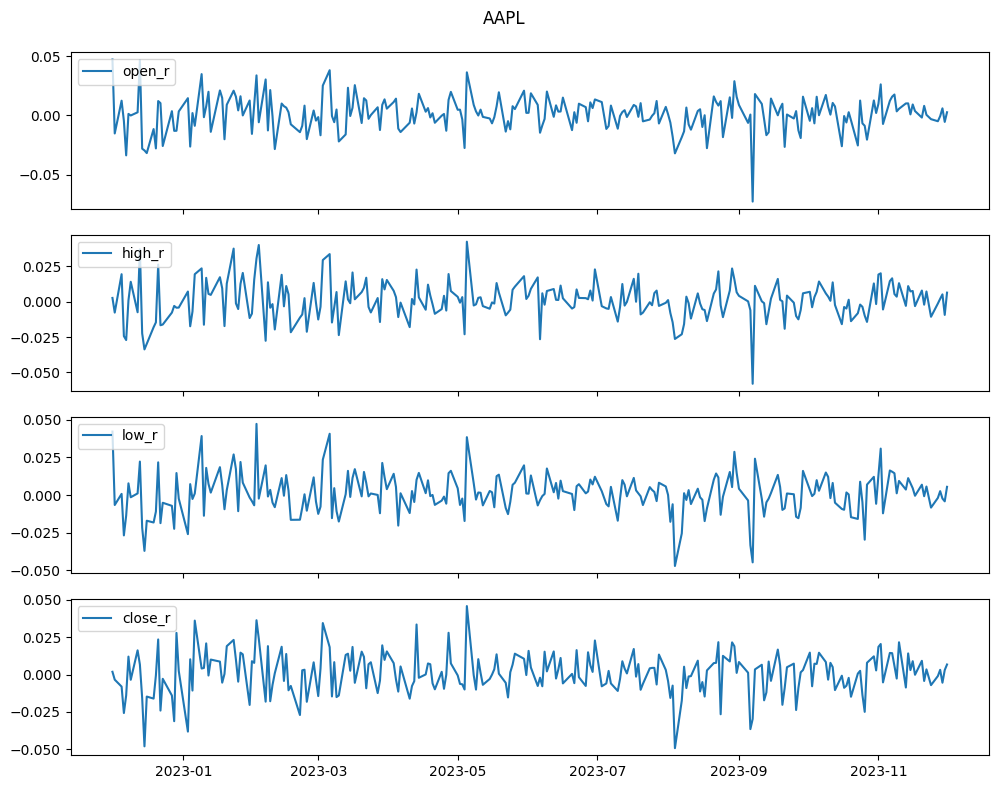

In [13]:
subset = stock_price.full_df.tail(252)
plot_return(
    subset[['date','open_r']].set_index('date').squeeze(),
    subset[['date','high_r']].set_index('date').squeeze(),
    subset[['date','low_r']].set_index('date').squeeze(),
    subset[['date','close_r']].set_index('date').squeeze(),
    symbol=stock_price.symbol,
)

Define a function to plot the candlestick chart on stock prices:

In [14]:
def candlestick(data: pd.DataFrame) -> None:
    """
    Generates a candlestick chart from a given DataFrame.

    This function creates a candlestick chart, commonly used in financial analysis 
    to depict the price movement of securities, derivatives, or currency. 
    It represents the high, low, open, and closing prices of a stock or 
    trading instrument over a specified period.

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing the stock market data with columns 'Date', 
        'Open', 'High', 'Low', 'Close', and 'Volume'.

    Returns
    -------
    None
        Displays the candlestick chart.
    """

    # Convert 'Date' column to datetime and set as index
    data['date'] = pd.to_datetime(data['date'])
    data = data.set_index('date')
    # Create subplot layout for candlestick and volume plots
    _, axes = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
    # Define market colors and style for the plot
    mc = mpf.make_marketcolors(up='green', down='red', volume='black', inherit=True)
    s  = mpf.make_mpf_style(marketcolors=mc)
    # Plotting the candlestick chart
    mpf.plot(data, type='candle', ax=axes[0], volume=axes[1], style=s, show_nontrading=False)
    # Adjusting the plot spines for aesthetics
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
    # Keep the x-axis visible on the volume subplot
    axes[1].spines['bottom'].set_visible(True)
    # Display the plot
    plt.show()

Show the last 252-day trading data:

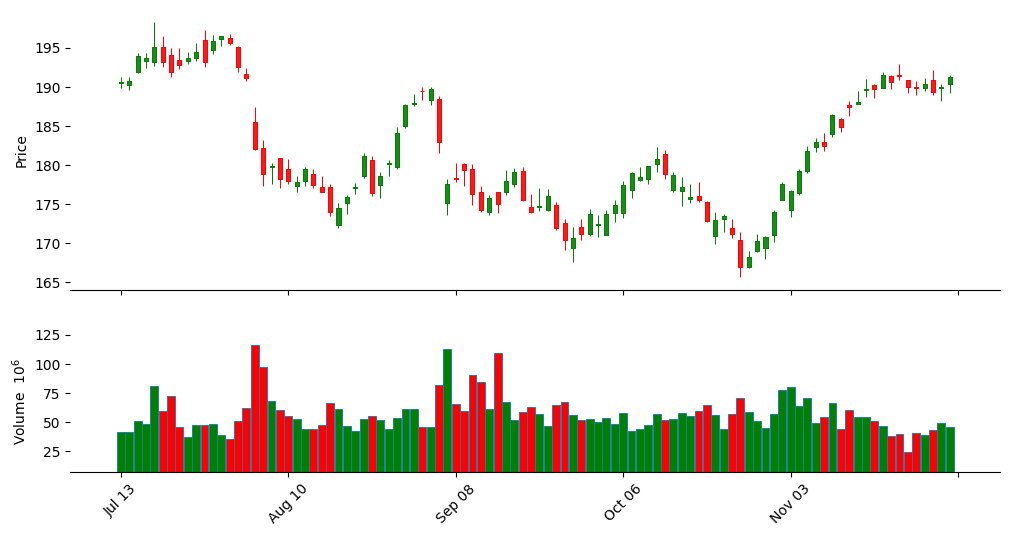

In [15]:
candlestick(
    stock_price.full_df[['date','open','high','low','close','volume']].tail(100)
)

Analyzing the return plots and the candlestick chart of a stock like AAPL can lead us to focus on several key areas for our EDA:

1. Exploring Price Return Distributions: Understanding how the stock's price returns are distributed is a crucial step in model development
2. Examining the Open-Close Relationship: Investigating the correlation between opening and closing prices is crucial. A strong relationship (if any) could allow us to use the opening price as a reliable indicator for predicting the closing price
3. Analyzing Volume-Price Change Correlation: Studying how changes in trading volume relate to the stock's price movements can provide valuable insights for predictive modeling

### 3.2. Univariate Analysis: Price Return Distribution

Define a function for boxplot and distribution plot of a single variable:

In [16]:
# Import libraries
import seaborn as sns

In [17]:
def univariate_numerical(data: pd.Series):
    
    """
    This function performs univariate analysis on a numerical variable using seaborn
    It generates a boxplot and a histogram with a Kernel Density Estimate (KDE).

    Parameters:
    ----------
    - data: pd.Series
        A named Pandas Series object containing numerical data for analysis.

    The function creates a two-subplot figure:
    - The first subplot is a boxplot, which provides information about the median,
    quartiles, and outliers of the distribution.
    - The second subplot is a histogram with a KDE curve that provides
    a smooth estimate of the distribution.
    """

    # Create a new figure for the plots.
    plt.figure()

    # Create the first subplot: a boxplot for the data series.
    plt.subplot(121)  # 1 row, 2 columns, 1st subplot
    sns.boxplot(data, orient='v')  # 'v' for vertical orientation
    plt.title(f'Boxplot of {data.name}')  # Set the title with the series' name
    plt.xlabel('')  # No label for the x-axis

    # Create the second subplot: a histogram with a KDE.
    plt.subplot(122)  # 1 row, 2 columns, 2nd subplot
    # Generate a histogram with KDE; adjust the bandwidth for smoothing.
    ax = sns.histplot(data, bins=20, kde=True, kde_kws={"bw_adjust": 3})
    ax.set_ylabel('')  # No label for the y-axis
    plt.title(f'Histogram of {data.name}')  # Set the title with the series' name

    # Display the figure with both subplots.
    plt.show()

First, have a look into raw data of log return on close prices. This raw return can be obtained from our property `full_df`, which is a Dataframe that contains all historical returns.

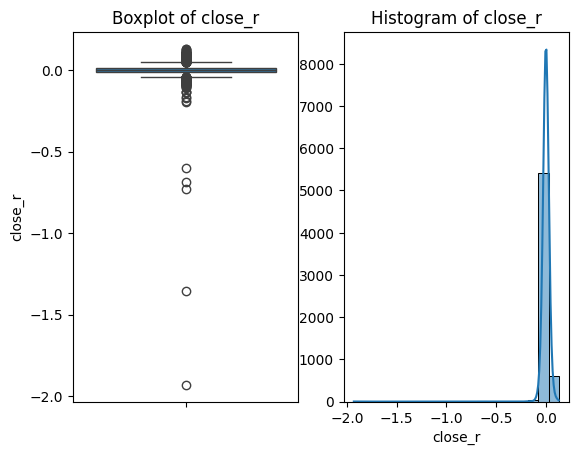

In [18]:
univariate_numerical(stock_price.full_df['close_r'])

Occasional artificial shifts in stock prices, such as those caused by stock splits, reverse stock split, or dividends, can significantly affect their distribution. A boxplot analysis revealing extremely negative values in stock returns suggests a substantial leftward skew in the distribution.

Removing these extreme values, as done in the `train_df`, `validation_df`, and `test_df`, results in a dataset that is more representative of the typical market behavior:

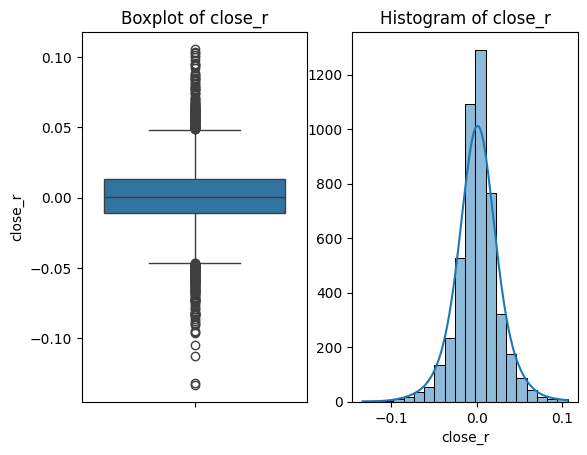

In [19]:
univariate_numerical(stock_price.train_df['close_r'])

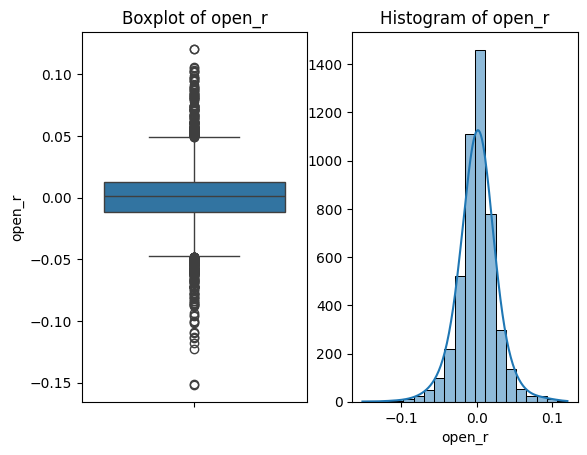

In [20]:
univariate_numerical(stock_price.train_df['open_r'])

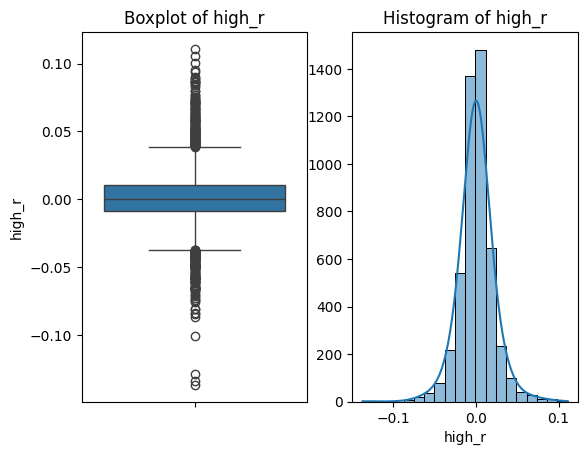

In [21]:
univariate_numerical(stock_price.train_df['high_r'])

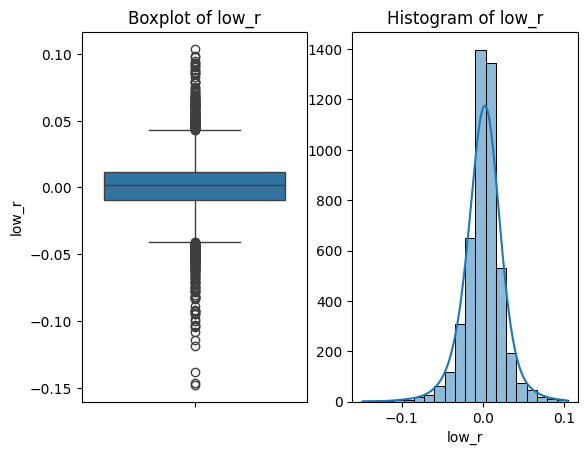

In [22]:
univariate_numerical(stock_price.train_df['low_r'])

Now, the returns are bell-shaped and symmetrically centered around 0.

This also seems true for volume's rate of change:

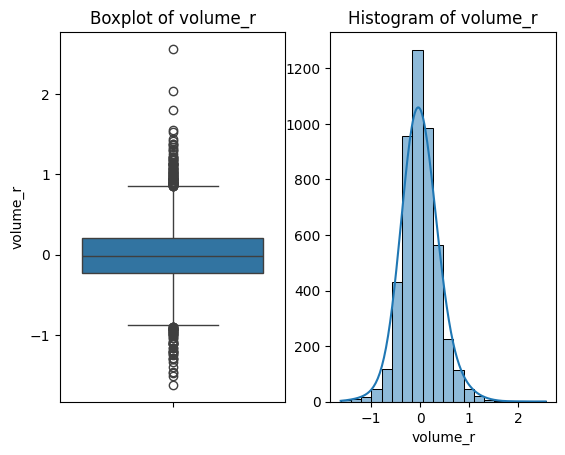

In [23]:
univariate_numerical(stock_price.train_df['volume_r'])

### 3.3. Bivariate Analysis:

We need a function to plot the relationship between 2 numerical variables:

In [24]:
def bivariate_numerical_numerical(data: pd.DataFrame, x: str, y: str):
    """
    Create a bivariate scatter plot using Seaborn to visualize the relationship between two numerical variables.
    
    Parameters:
    ----------
    - data: pd.DataFrame
        The Pandas DataFrame containing the data.
    - x: str
        The name of the column in the DataFrame to be used as the x-axis in the scatter plot.
    - y: str
        The name of the column in the DataFrame to be used as the y-axis in the scatter plot.
    
    The function plots a scatter plot where each point represents an observation with its x and y values.
    """
    # Create a new figure for plotting.
    plt.figure()
    # Plot a scatter plot with the specified columns as the x and y axes.
    # `linewidth=0` removes the outline of the markers.
    sns.scatterplot(x=x, y=y, data=data, linewidth=0)
    # Set the title of the plot. The title indicates the variables being compared.
    plt.title(f'{x} vs. {y}')
    # Display the plot.
    plt.show()

#### 3.3.1. Examining the Open-Close Relationship:

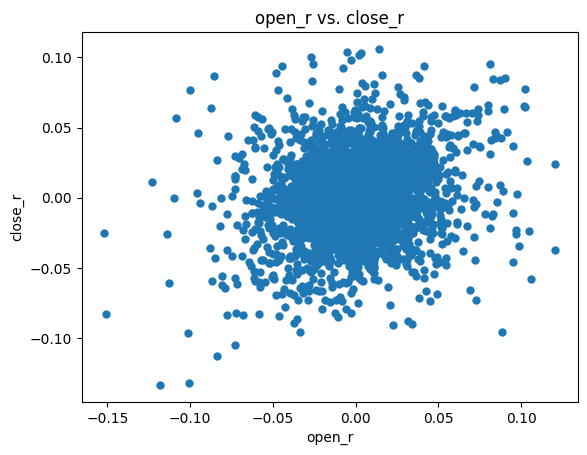

In [25]:
bivariate_numerical_numerical(data=stock_price.train_df, x='open_r', y='close_r')

Life is not easy. The return of opening price, which can be obtained at the begining of the trading session, has no thing to tell with the return of closing price at the end of the day. A regression model relying only on the opening price to predict the closing price in hope of gaining some in-day profit would never work!

#### 3.3.2. Analyzing Volume-Price Change Correlation:

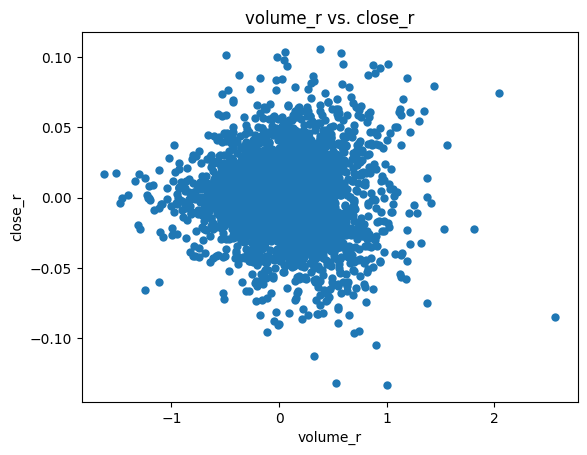

In [26]:
bivariate_numerical_numerical(data=stock_price.train_df, x='volume_r', y='close_r')

Similarly, volumes have nothing to do with prices.

#### 3.3.3. Conclusion:

The findings from our bivariate analysis indicate that using intraday data alone may be insufficient for accurately predicting the closing price of a stock. This challenge signifies the need for time series or sequential modeling approaches. Such methods could capture the temporal dependencies and complex patterns inherent in stock price movements over time.

## Part 4: Modeling

### 4.1. Planning:

In this section, we focus on the application of various deep learning models to predict stock closing prices. Each of the proposed models come with its unique strengths in handling time series data:

1. <b>Multilayer Perceptron (MLP):</b><br>This is a basic form of neural network. MLPs are composed of multiple layers of nodes, each connected to all nodes in the adjacent layers. When using MLP, we implicitly assume the temporal dependencies or order of the data are not significant. While this assumption is rarely valid in time series problems, we will attempt to see this oversimplified approach could deliver a decent outcome.

2. <b>1D Convolutional Neural Network (Conv1D):</b><br>Primarily known for their success in image processing, Conv1D networks are adept at capturing local patterns in time series data. Their convolutional layers can identify trends and features in sequential data. This characteristic makes them effective for analyzing stock price movements.

3. <b>Long Short-Term Memory (LSTM):</b><br>LSTMs are a type of recurrent neural network specifically designed for learning long-term dependencies. They are capable of remembering information over extended periods, which is important for stock price analysis.

4. <b>Gated Recurrent Unit (GRU):</b><br>GRUs are a simplified variation of LSTM. They are efficient in capturing long-term dependencies but with fewer parameters, leading to faster training times and reduced computational costs.

5. <b>Bidirectional Model:</b><br>Bidirectional models process data forwards and backwards simultaneously. This dual-direction approach allows them to uncover long-term dependencies in the data in both directions. This characteristic makes them well handle complex sequences, like stock prices.

Moreover, we will develop a naive model which predicts the future prices simply based on the average value observed in `close_r` feature across various time points. 
$$
\widehat{close}(t+1) = close(t) \times \exp\left[\frac{1}{N}\sum_{i=1}^{N} close_{r}(t-i)\right]

$$
This naive model serves as a baseline in our model selection process. By comparing advanced models against this naive model, we can assess the added value and effectiveness of more complex modeling techniques.

### 4.2. Implementation:

#### 4.2.0. Custom Log

The `CustomLog` class is designed for logging during model training. The printing logic is implemented in the `on_epoch_end` method. This method prints logs at the end of every 10th epoch such that each metric key is left-aligned with a fixed width, ensuring consistent formatting, while the corresponding values are displayed with nine decimal places for precision. A separator line is also printed following the key-value pairs for enhanced readability. 

This custom callback provides a less verbose representation compared to the default logging mechanism to monitor model performance metrics at regular intervals during training.

In [27]:
class CustomLog(tf.keras.callbacks.Callback):
    """
    A custom callback class for TensorFlow's Keras API to log training metrics.

    This class is designed to print training metrics in a less verbose manner than the default
    TensorFlow logger, providing clear, periodic updates on the model's performance during training.
    """

    def on_epoch_end(self, epoch: int, logs: dict = None):
        """
        Called at the end of an epoch during model training.

        Parameters:
        ----------
        epoch : int
            The index of the epoch.
        logs : dict
            A dictionary containing training metrics.
        """
        # Check if it's time to log (every 10 epochs)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}:")
            # Iterate through and print each metric
            for key, value in logs.items():
                # Format and align the metric key and value
                print(f"{key.ljust(25)}: {value:<.9f}")
            # Print a separator for readability
            print('--------------------')


#### 4.2.1. BaseModel

In developing deep learning models, one of the most efficient ways to keep our code DRY (don't repeat yourself) and flexible for fine-tuning is to write up a `BaseModel` abstract class. This class encapsulates all shared functionalities of concrete models and outlines abstract methods that its subclasses must implement. This approach streamlines code maintenance and the process of experimenting models.

In [28]:
import abc

In [29]:
class BaseModel(abc.ABC):

    """
    Base class for different deep learning models for stock price prediction.

    This class provides common functionalities / interfaces for various models to handle
    configuring, training, evaluation, and prediction for time series data.
    """

    def __init__(self) -> None:
        # Placeholder for the model instance
        self.model: typing.Optional[tf.keras.Model] = None

    def evaluate(self, test_set: tf.data.Dataset) -> list:
        """
        Evaluate the model on an unseen dataset.

        Parameters:
        ----------
        test_set : tf.data.Dataset
            The dataset on which to evaluate the model.

        Returns:
        -------
        list
            The evaluation result of the model.
        """
        return self.model.evaluate(x=test_set)

    def predict(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Use the model to predict on new data.

        Parameters:
        ----------
        data : pd.DataFrame
            Input data for making predictions.

        Returns:
        -------
        pd.DataFrame
            The DataFrame containing predicted values.
        """
        # Predict returns using the model
        predicted_returns = self.model.predict(
            x=data[['open_r','high_r','low_r','close_r','volume_r']].to_numpy()[np.newaxis,...],
            batch_size=1,
        ).reshape(-1,)
        # Calculate predicted prices from returns
        last_price = data.iloc[-1, data.columns.get_loc('close')]
        last_date = data.iloc[-1, data.columns.get_loc('date')]
        predicted_prices = [last_price]
        for r in predicted_returns:
            predicted_prices.append(np.exp(r) * predicted_prices[-1])
        predicted_prices.pop(0)
        # Prepare DataFrame for predicted data
        predicted_dates = pd.date_range(
            start=last_date, 
            periods=len(predicted_prices) + 1, 
            freq=pd.tseries.offsets.BDay()
        ).date.tolist()[1:]
        predicted_data = pd.DataFrame(
            data={
                'date': predicted_dates, 
                'type': 'predicted', 
                'price': predicted_prices
            }
        ).astype({'date': 'datetime64[ns]'})
        # Combine actual and predicted data
        actual_data = data[['date','close']].rename({'close': 'price'}, axis=1)
        actual_data.insert(loc=1, column='type', value='actual')
        
        return pd.concat(
            [actual_data, predicted_data], axis=0
        ).reset_index(drop=True)

    def fit(
        self, 
        train_set: tf.data.Dataset, 
        validation_set: tf.data.Dataset, 
        max_epochs: int, 
        learning_rate: float
    ) -> tf.keras.callbacks.History:

        """
        Fits the model to the training data.

        Parameters:
        ----------
        train_set : tf.data.Dataset
            The training dataset.
        validation_set : tf.data.Dataset
            The validation dataset.
        max_epochs : int
            The maximum number of epochs for training.
        learning_rate : float
            The learning rate for the optimizer.

        Returns:
        -------
        tf.keras.callbacks.History
            The History object containing training and validation loss and metrics values.
        """
        # Prepare for model building
        first_input_tensor, first_output_tensor = next(iter(train_set))
        feature_dataset = train_set.map(lambda features, labels: features)
        # Build and compile the model if not already done
        normalizer_name = 'normalizer'
        if self.model is None:
            normalizer = tf.keras.layers.Normalization(axis=-1, name=normalizer_name)
            normalizer.adapt(feature_dataset)
            self._build_model(
                input_shape=first_input_tensor.shape[-2:], 
                output_units=first_output_tensor.shape[-1], 
                normalizer=normalizer,
            )
            self.model.compile(
                optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate),
                loss=tf.keras.losses.MeanSquaredError(), 
                metrics=[tf.keras.metrics.MeanAbsoluteError()],
            )
        elif normalizer_name in [layer.name for layer in self.model.layers]:
            # Adapt the normalization layer to the training data
            normalization_layer = self.model.get_layer(name=normalizer_name)
            normalization_layer.reset_state()
            normalization_layer.adapt(feature_dataset)

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            start_from_epoch=64,
            restore_best_weights=True,
        )
        # Fit the model to the training data
        return self.model.fit(
            train_set,
            epochs=max_epochs,
            validation_data=validation_set,
            callbacks=[early_stopping, CustomLog()] if validation_set is not None else [CustomLog()],
            verbose=0,
        )

    @abc.abstractmethod
    def _build_model(
        self, 
        input_shape: typing.Tuple[int, int], 
        output_units: int,
        normalizer: tf.keras.layers.Normalization,
    ) -> None:
    
        """
        Abstract method to build the model. This method must be implemented by subclasses.
        It defines the architecture of the model, including layers and their configurations.

        Parameters:
        ----------
        input_shape : Tuple[int, int]
            The shape of the input data, excluding the batch size. This helps in defining 
            the input layer of the model.
        output_units : int
            The number of units in the output layer, determining the shape of the output 
            produced by the model.
        normalizer : tf.keras.layers.Layer
            A normalization layer that can be applied to the input data. This layer is 
            responsible for standardizing or normalizing the input features.

        Returns:
        -------
        None
            The method does not return anything but must set the `self.model` attribute 
            with the constructed model.
        """
        pass

The methods in our BaseModel class effectively serve as thin wrappers around TensorFlow's corresponding methods, such as `.fit() `and `.predict()`. Each of these methods is designed to call the standard TensorFlow functionality but with additional custom features so that they enhance convenience for our specific problem:

- The `predict()` method is responsible for making predictions on new data. It extracts the necessary features, uses the model to predict returns, and then computes the predicted stock prices from these returns. The method constructs a DataFrame combining both actual and predicted values for easy comparison and analysis.

- The crucial `fit()` method manages the training process of the model. It involves building the model (if not already built), compiling it with an optimizer and loss function, and fitting it to the training data. The method also implements early stopping to prevent overfitting.

The protected method `_build_model()` in the `BaseModel` class is designed for implementation by concrete model subclasses. It is where the architecture of a model is defined. The `BaseModel` provides a flexible and extensible interface for experimenting with an unlimited number of models. Each subclass can easily customize its own architecture while still leveraging the common training, prediction, and evaluation functionalities provided by the BaseModel. This approach greatly simplifies the process of testing and comparing different models in the task of stock price prediction.

#### 4.2.2. Naive Model

We can easily construct our Naive Model (described earlier) by subclassing the `BaseModel` and implementing `_build_model()` method:

In [30]:
class NaiveModel(BaseModel):

    # implement
    def _build_model(
        self, 
        input_shape: typing.Tuple[int, int], 
        output_units: int,
        normalizer: tf.keras.layers.Normalization,
    ) -> None:
        # Define model
        inputs = tf.keras.Input(shape=input_shape)
        # compute the average of all features over all time points
        x = tf.keras.layers.GlobalAveragePooling1D()(inputs)
        # get the average of the 3rd feature (close_r)
        x = tf.keras.layers.Lambda(lambda x: x[:, 3:4])(x)
        # propagate the same prediction over all output units
        outputs = tf.keras.layers.Lambda(
            lambda x: tf.repeat(x, repeats=output_units, axis=1)
        )(x)
        self.model = tf.keras.Model(
            inputs=inputs, 
            outputs=outputs, 
            name=self.__class__.__name__
        )

In [31]:
naive = NaiveModel()

Let's "train" this model and evaluate it on the test to obtain the baseline performance that more complex models should surpass. Note that this model has no trainable parameters, "training" it simply means calculating the average of historical returns. And also because of this, it makes no sense to train the model on more than 1 epoch:

In [32]:
# Train the naive model
naive_history = naive.fit(
    train_set=train_set, 
    validation_set=validation_set, 
    max_epochs=1,
    learning_rate=1e-3,
)

In [33]:
# Evaluate the naive model on `test_set` to get the baseline performance:
baseline_loss, baseline_mae = naive.evaluate(test_set=test_set)

8/8 [==============================] - 0s 863us/step - loss: 3.4450e-04 - mean_absolute_error: 0.0139


In [34]:
# Show the baseline loss and mae
print(baseline_loss, baseline_mae)

0.00034450148814357817 0.013859548605978489


As we can see, the worst MAE we should achieve is approximately 0.0139. Since we are effectively doing a 5-value prediction for 5 daily returns (`stock_price.n_days_forward = 5`), the baseline average MAE of daily return is:

In [35]:
print(f'Avg. MAE of daily return: {baseline_mae / stock_price.n_days_forward * 100}%')

Avg. MAE of daily return: 0.2771909721195698%


#### 4.2.2. Multilayer Perceptron

The MLP (Multilayer Perceptron) model simplifies the complex task of predicting stock prices by assuming that temporal dependencies in the data are not significantly influential. Instead, it focuses on individual data points, analyzing them in isolation. Such simplification can be particularly advantageous when the relationships within the data are static and less dependent on their sequence in time. 

Let's make this assumption and try configuring our MLP models.

##### <b>First experiment:</b>

We will try an MLP which flattens the temporal sequences and passes it forward to 3 Dense layers, which have 128, 64, and 32 units, respectively. 

ReLU (Rectified Linear Unit) is used for hidden layers primarily because its simple, linear nature for positive values ensures efficient computation, while its non-linear characteristics enable the network to learn complex patterns in the data.

The output layer employs the tanh activation function, which is ideal for this application as it outputs values in the -1 to 1 range. This range aligns perfectly with the nature of stock return predictions

In [36]:
class MLP(BaseModel):

    # implement
    def _build_model(self, input_shape, output_units, normalizer):
        # Define model
        inputs = tf.keras.Input(shape=input_shape)
        x = normalizer(inputs)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu)(x)
        x = tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu)(x)
        x = tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu)(x)
        outputs = tf.keras.layers.Dense(units=output_units, activation=tf.keras.activations.tanh)(x)
        self.model = tf.keras.Model(
            inputs=inputs, 
            outputs=outputs, 
            name=self.__class__.__name__
        )

We train the models for a maximum of 256 epochs and a learning rate of 1e-3:

In [37]:
mlp = MLP()
mlp_history = mlp.fit(
    train_set=train_set,
    validation_set=validation_set, 
    max_epochs=256,
    learning_rate=1e-3,
)

Epoch 10:
loss                     : 0.001595450
mean_absolute_error      : 0.017989291
val_loss                 : 0.004179958
val_mean_absolute_error  : 0.018711848
--------------------
Epoch 20:
loss                     : 0.001583761
mean_absolute_error      : 0.018003348
val_loss                 : 0.004179571
val_mean_absolute_error  : 0.018637426
--------------------
Epoch 30:
loss                     : 0.001576090
mean_absolute_error      : 0.017985679
val_loss                 : 0.004179824
val_mean_absolute_error  : 0.018559618
--------------------
Epoch 40:
loss                     : 0.001570504
mean_absolute_error      : 0.017987484
val_loss                 : 0.004178333
val_mean_absolute_error  : 0.018591974
--------------------
Epoch 50:
loss                     : 0.001578966
mean_absolute_error      : 0.018008051
val_loss                 : 0.004179026
val_mean_absolute_error  : 0.018658405
--------------------
Epoch 60:
loss                     : 0.001566222
mean_absolute_er

In [38]:
mlp_loss, mlp_mae = mlp.evaluate(test_set=test_set)
print(f'MLP outperforms the baseline model: {mlp_mae < baseline_mae}')

8/8 [==============================] - 0s 2ms/step - loss: 3.5712e-04 - mean_absolute_error: 0.0141
MLP outperforms the baseline model: False


The model underperformed compared to the baseline, likely due to its current structure consisting solely of Dense layers.

##### <b>Second experiment:</b>

A common strategy to enhance a model's feature robustness is the integration of Dropout layers among these Dense layers. Dropout layers, by randomly deactivating neurons during training, force the network to learn more robust features, ensuring effective functioning with various neuron subsets. 

As an attempt to improve our model, our next experiment will involve incorporating Dropout layers, aiming to enhance its robustness and overall performance.

In [39]:
class MLP(BaseModel):

    # implement
    def _build_model(self, input_shape, output_units, normalizer):
        # Define model
        inputs = tf.keras.Input(shape=input_shape)
        x = normalizer(inputs)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu)(x)
        x = tf.keras.layers.Dropout(rate=0.5)(x)
        x = tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu)(x)
        x = tf.keras.layers.Dropout(rate=0.5)(x)
        x = tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu)(x)
        x = tf.keras.layers.Dropout(rate=0.5)(x)
        outputs = tf.keras.layers.Dense(units=output_units, activation=tf.keras.activations.tanh)(x)
        self.model = tf.keras.Model(
            inputs=inputs, 
            outputs=outputs, 
            name=self.__class__.__name__
        )

We train the models for a maximum of 256 epochs and a learning rate of 1e-3:

In [40]:
mlp = MLP()
mlp_history = mlp.fit(
    train_set=train_set, 
    validation_set=validation_set, 
    max_epochs=256,
    learning_rate=1e-3,
)

Epoch 10:
loss                     : 0.001699907
mean_absolute_error      : 0.018142171
val_loss                 : 0.004178618
val_mean_absolute_error  : 0.018650902
--------------------
Epoch 20:
loss                     : 0.001676458
mean_absolute_error      : 0.018015623
val_loss                 : 0.004178372
val_mean_absolute_error  : 0.018621383
--------------------
Epoch 30:
loss                     : 0.001687484
mean_absolute_error      : 0.018002486
val_loss                 : 0.004179523
val_mean_absolute_error  : 0.018763803
--------------------
Epoch 40:
loss                     : 0.001690441
mean_absolute_error      : 0.018021075
val_loss                 : 0.004179162
val_mean_absolute_error  : 0.018719254
--------------------
Epoch 50:
loss                     : 0.001688503
mean_absolute_error      : 0.018023510
val_loss                 : 0.004179860
val_mean_absolute_error  : 0.018739665
--------------------
Epoch 60:
loss                     : 0.001700894
mean_absolute_er

In [ ]:
mlp_loss, mlp_mae = mlp.evaluate(test_set=test_set)
print(f'MLP outperforms the baseline model: {mlp_mae < baseline_mae}')

The fine-tuned model still underperformed the baseline, this could suggest that ignoring the temporal trends in stock returns is not a good idea. It's likely that future stock prices are significantly influenced by their historical trends and patterns. 

Moving forward, we will focus on exploring more sophisticated models specifically designed for time-series data. These models will aim to effectively capture and utilize time-related information.

#### 4.2.3. 1-Dimensional Convolutional Neural Network (Conv1D)

Conv1D models excel in identifying local patterns and trends in sequential data. For stock prices, which often exhibit short-term fluctuations and trends, Conv1D models might efficiently capture these temporal features. 

##### <b>First experiment:</b>

The first Conv1D model is designed for time-series data, utilizing 1D convolutional layers. It begins with normalized inputs, followed by three convolutional layers with increasing filter sizes (16, 32, 64) and a kernel size of 10, all using ReLU activation. These layers are effective in extracting local features and patterns from the time-series data. 

MaxPooling layers were added among the Conv1D layers to reduce the dimensionality of the feature maps, enabling the model to extract and retain the most significant features while reducing computational complexity and mitigating overfitting.

After processing through these layers, the data undergoes global average pooling to condense the features, and finally, a Dense layer with a tanh activation outputs the prediction. The reason for using the tanh function in the last layer is also because it perfectly fits the problem of predicting stock returns.

In [ ]:
class Conv1D(BaseModel):

    # implement
    def _build_model(self, input_shape, output_units, normalizer) -> None:
        # Define model
        inputs = tf.keras.Input(shape=input_shape)
        x = normalizer(inputs)
        x = tf.keras.layers.Conv1D(filters=16, kernel_size=10, activation=tf.keras.activations.relu)(x)
        x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
        x = tf.keras.layers.Conv1D(filters=32, kernel_size=10, activation=tf.keras.activations.relu)(x)
        x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
        x = tf.keras.layers.Conv1D(filters=64, kernel_size=10, activation=tf.keras.activations.relu)(x)
        x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        outputs = tf.keras.layers.Dense(units=output_units, activation=tf.keras.activations.tanh)(x)
        self.model = tf.keras.Model(
            inputs=inputs, 
            outputs=outputs, 
            name=self.__class__.__name__
        )

We train the models for a maximum of 256 epochs and a learning rate of 1e-3:

In [43]:
conv1d = Conv1D()
conv1d_history = conv1d.fit(
    train_set=train_set, 
    validation_set=validation_set, 
    max_epochs=256,
    learning_rate=1e-3,
)

Epoch 10:
loss                     : 0.001656095
mean_absolute_error      : 0.017916169
val_loss                 : 0.004193547
val_mean_absolute_error  : 0.019364985
--------------------
Epoch 20:
loss                     : 0.001583568
mean_absolute_error      : 0.017826732
val_loss                 : 0.004240055
val_mean_absolute_error  : 0.019558599
--------------------
Epoch 30:
loss                     : 0.001476660
mean_absolute_error      : 0.017607709
val_loss                 : 0.004246106
val_mean_absolute_error  : 0.020666417
--------------------
Epoch 40:
loss                     : 0.001361457
mean_absolute_error      : 0.017533397
val_loss                 : 0.004262449
val_mean_absolute_error  : 0.021600548
--------------------
Epoch 50:
loss                     : 0.001257009
mean_absolute_error      : 0.017402468
val_loss                 : 0.004341648
val_mean_absolute_error  : 0.022211997
--------------------
Epoch 60:
loss                     : 0.001190030
mean_absolute_er

In [44]:
conv1d_loss, conv1d_mae = conv1d.evaluate(test_set=test_set)
print(f'Conv1D outperforms the baseline model: {conv1d_mae < baseline_mae}')

8/8 [==============================] - 0s 4ms/step - loss: 4.7599e-04 - mean_absolute_error: 0.0171
Conv1D outperforms the baseline model: False


We still cannot surpass the baseline. The training log indicates significantly higher MAE on validation than on training. It suggested that the model is overfitting the data. We will need some sort of regularization.

##### <b>Second experiment:</b>

To better regularize the model and make it more generalizable to unseen data, we will add some Dropout layers among the Conv1D/MaxPool1D blocks. This technique helps in preventing the model from becoming too complex by penalizing over-reliance on any single feature or pattern, thereby encouraging the model to learn more generalized representations.

In [45]:
class Conv1D(BaseModel):

    # implement
    def _build_model(self, input_shape, output_units, normalizer) -> None:
        # Define model
        inputs = tf.keras.Input(shape=input_shape)
        x = normalizer(inputs)
        x = tf.keras.layers.Conv1D(filters=16, kernel_size=10, activation=tf.keras.activations.relu)(x)
        x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
        x = tf.keras.layers.Dropout(rate=0.5)(x)
        x = tf.keras.layers.Conv1D(filters=32, kernel_size=10, activation=tf.keras.activations.relu)(x)
        x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
        x = tf.keras.layers.Dropout(rate=0.5)(x)
        x = tf.keras.layers.Conv1D(filters=64, kernel_size=10, activation=tf.keras.activations.relu)(x)
        x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
        x = tf.keras.layers.Dropout(rate=0.5)(x)
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        outputs = tf.keras.layers.Dense(units=output_units, activation=tf.keras.activations.tanh)(x)
        self.model = tf.keras.Model(
            inputs=inputs, 
            outputs=outputs, 
            name=self.__class__.__name__
        )

We train the models for a maximum of 256 epochs and a learning rate of 1e-3:

In [46]:
conv1d = Conv1D()
conv1d_history = conv1d.fit(
    train_set=train_set, 
    validation_set=validation_set, 
    max_epochs=256,
    learning_rate=1e-3,
)

Epoch 10:
loss                     : 0.001687097
mean_absolute_error      : 0.018026099
val_loss                 : 0.004180370
val_mean_absolute_error  : 0.018850345
--------------------
Epoch 20:
loss                     : 0.001686940
mean_absolute_error      : 0.018007984
val_loss                 : 0.004180388
val_mean_absolute_error  : 0.018710712
--------------------
Epoch 30:
loss                     : 0.001686940
mean_absolute_error      : 0.018011581
val_loss                 : 0.004178667
val_mean_absolute_error  : 0.018646285
--------------------
Epoch 40:
loss                     : 0.001686377
mean_absolute_error      : 0.018018138
val_loss                 : 0.004179358
val_mean_absolute_error  : 0.018746499
--------------------
Epoch 50:
loss                     : 0.001687388
mean_absolute_error      : 0.018018894
val_loss                 : 0.004179634
val_mean_absolute_error  : 0.018765230
--------------------
Epoch 60:
loss                     : 0.001687392
mean_absolute_er

In [47]:
conv1d_loss, conv1d_mae = conv1d.evaluate(test_set=test_set)
print(f'Conv1D outperforms the baseline model: {conv1d_mae < baseline_mae}')

8/8 [==============================] - 0s 3ms/step - loss: 3.4920e-04 - mean_absolute_error: 0.0140
Conv1D outperforms the baseline model: False


Once again, our model continues to fall short of the baseline's performance. Adding Dropout layers makes our model not able to retain the necessary information (the training loss is stuck across epochs). Let's try removing these Dropout layers, stacking more Conv1Ds and increasing the kernel size. By doing so, we hope for capturing longer dependencies across time points in the data.

##### <b>Third experiment:</b>

Here we add a fourth convolutional layer, remove Dropouts, and increase the kernel size to 15

In [48]:
class Conv1D(BaseModel):

    # implement
    def _build_model(self, input_shape, output_units, normalizer) -> None:
        # Define model
        inputs = tf.keras.Input(shape=input_shape)
        x = normalizer(inputs)
        x = tf.keras.layers.Conv1D(filters=16, kernel_size=15, activation=tf.keras.activations.relu)(x)
        x = tf.keras.layers.Conv1D(filters=32, kernel_size=15, activation=tf.keras.activations.relu)(x)
        x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
        x = tf.keras.layers.Conv1D(filters=64, kernel_size=15, activation=tf.keras.activations.relu)(x)
        x = tf.keras.layers.Conv1D(filters=128, kernel_size=15, activation=tf.keras.activations.relu)(x)
        x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        outputs = tf.keras.layers.Dense(units=output_units, activation=tf.keras.activations.tanh)(x)
        self.model = tf.keras.Model(
            inputs=inputs, 
            outputs=outputs, 
            name=self.__class__.__name__
        )

We train the models for a maximum of 256 epochs and a learning rate of 1e-3:

In [ ]:
conv1d = Conv1D()
conv1d_history = conv1d.fit(
    train_set=train_set, 
    validation_set=validation_set, 
    max_epochs=256,
    learning_rate=1e-3,
)

In [50]:
conv1d_loss, conv1d_mae = conv1d.evaluate(test_set=test_set)
print(f'Conv1D outperforms the baseline model: {conv1d_mae < baseline_mae}')

8/8 [==============================] - 0s 4ms/step - loss: 3.7332e-04 - mean_absolute_error: 0.0145
Conv1D outperforms the baseline model: False


No matter what we tried, Conv1D seems not to work at all.

#### 4.2.4. Long-Short Term Memory (LSTM)

LSTMs are specially designed to address the challenges of sequential data with long-term dependencies. Their architecture allows them to remember and leverage information over extended periods, which is crucial in stock price prediction where past trends and patterns significantly influence future movements. 

##### <b>First experiment:</b>

We construct a LSTM model. The architecture begins with an input layer followed by normalization. The core of the model consists of two LSTM (Long Short-Term Memory) layers: the first with 32 units, and the second with 16 units, both using the tanh activation function. The first LSTM layer returns sequences to the next, while the second does not, preparing for output. Finally, a Dense output layer with a tanh activation function generates the final predictions. This structure leverages LSTM's ability to capture long-term dependencies in time-series data.

In [ ]:
class LSTM(BaseModel):

    # implement
    def _build_model(self, input_shape, output_units, normalizer) -> None:
        # Define model
        inputs = tf.keras.Input(shape=input_shape)
        x = normalizer(inputs)
        x = tf.keras.layers.LSTM(units=32, activation=tf.keras.activations.tanh, return_sequences=True)(x)
        x = tf.keras.layers.LSTM(units=16, activation=tf.keras.activations.tanh, return_sequences=False)(x)
        outputs = tf.keras.layers.Dense(units=output_units, activation=tf.keras.activations.tanh)(x)
        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [52]:
lstm = LSTM()
lstm_history = lstm.fit(
    train_set=train_set, 
    validation_set=validation_set, 
    max_epochs=256,
    learning_rate=1e-3,
)

Epoch 10:
loss                     : 0.001682578
mean_absolute_error      : 0.018324168
val_loss                 : 0.004209665
val_mean_absolute_error  : 0.019195035
--------------------
Epoch 20:
loss                     : 0.001654769
mean_absolute_error      : 0.018197525
val_loss                 : 0.004209008
val_mean_absolute_error  : 0.019234259
--------------------
Epoch 30:
loss                     : 0.001619589
mean_absolute_error      : 0.018119369
val_loss                 : 0.004261738
val_mean_absolute_error  : 0.019738920
--------------------
Epoch 40:
loss                     : 0.001547047
mean_absolute_error      : 0.018446671
val_loss                 : 0.004280261
val_mean_absolute_error  : 0.019977663
--------------------
Epoch 50:
loss                     : 0.001357527
mean_absolute_error      : 0.018301424
val_loss                 : 0.004251280
val_mean_absolute_error  : 0.019662950
--------------------
Epoch 60:
loss                     : 0.001226633
mean_absolute_er

In [53]:
lstm_loss, lstm_mae = lstm.evaluate(test_set=test_set)
print(f'LSTM outperforms the baseline model: {lstm_mae < baseline_mae}')

8/8 [==============================] - 0s 8ms/step - loss: 3.7094e-04 - mean_absolute_error: 0.0145
LSTM outperforms the baseline model: False


The model does not outperform the baseline, it seems to overfit the data (`loss` is much smaller than `val_loss`). We will try regularizing the model.

##### <b>Second experiment:</b>

We add a Dropout layer after each LSTM layer to regularize the model.

In [54]:
class LSTM(BaseModel):

    # implement
    def _build_model(self, input_shape, output_units, normalizer) -> None:
        # Define model
        inputs = tf.keras.Input(shape=input_shape)
        x = normalizer(inputs)
        x = tf.keras.layers.LSTM(units=32, activation=tf.keras.activations.tanh, return_sequences=True)(x)
        x = tf.keras.layers.Dropout(rate=0.2)(x)
        x = tf.keras.layers.LSTM(units=16, activation=tf.keras.activations.tanh, return_sequences=False)(x)
        x = tf.keras.layers.Dropout(rate=0.2)(x)
        outputs = tf.keras.layers.Dense(units=output_units, activation=tf.keras.activations.tanh)(x)
        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)

We train the models for a maximum of 256 epochs and a learning rate of 1e-3:

In [55]:
lstm = LSTM()
lstm_history = lstm.fit(
    train_set=train_set,
    validation_set=validation_set,
    max_epochs=256,
    learning_rate=1e-3,
)

Epoch 10:
loss                     : 0.001685815
mean_absolute_error      : 0.018170187
val_loss                 : 0.004189060
val_mean_absolute_error  : 0.018777458
--------------------
Epoch 20:
loss                     : 0.001676196
mean_absolute_error      : 0.018119007
val_loss                 : 0.004210852
val_mean_absolute_error  : 0.019391118
--------------------
Epoch 30:
loss                     : 0.001653847
mean_absolute_error      : 0.018067457
val_loss                 : 0.004222613
val_mean_absolute_error  : 0.019368766
--------------------
Epoch 40:
loss                     : 0.001619914
mean_absolute_error      : 0.018345322
val_loss                 : 0.004235843
val_mean_absolute_error  : 0.019570643
--------------------
Epoch 50:
loss                     : 0.001548149
mean_absolute_error      : 0.018337371
val_loss                 : 0.004197136
val_mean_absolute_error  : 0.018990977
--------------------
Epoch 60:
loss                     : 0.001483833
mean_absolute_er

In [56]:
lstm_loss, lstm_mae = lstm.evaluate(test_set=test_set)
print(f'LSTM outperforms the baseline model: {lstm_mae < baseline_mae}')

8/8 [==============================] - 0s 8ms/step - loss: 3.6183e-04 - mean_absolute_error: 0.0144
LSTM outperforms the baseline model: False


It's not working. LSTM alone seems not very promising!

#### 4.2.5. Gated Recurrent Unit (GRU)

GRU is a simplified version of LSTM. It is effective in modeling sequential data but with a more streamlined architecture. They can capture temporal dependencies without the complexity and computational intensity of LSTMs.

We will experiment with a GRU model which starts with an input layer followed by normalization. It then sequentially processes data through two GRU layers, with the first containing 32 units and the second 16 units, both utilizing the tanh activation function.

In [57]:
class GRU(BaseModel):

    # implement
    def _build_model(self, input_shape, output_units, normalizer) -> None:
        # Define model
        inputs = tf.keras.Input(shape=input_shape)
        x = normalizer(inputs)
        x = tf.keras.layers.GRU(units=32, activation=tf.keras.activations.tanh, return_sequences=True)(x)
        x = tf.keras.layers.GRU(units=16, activation=tf.keras.activations.tanh, return_sequences=False)(x)
        # no ReLu activation because return can below 0
        outputs = tf.keras.layers.Dense(units=output_units, activation=tf.keras.activations.tanh)(x)
        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)

We train the models for a maximum of 256 epochs and a learning rate of 1e-3:

In [58]:
gru = GRU()
gru_history = gru.fit(
    train_set=train_set,
    validation_set=validation_set,
    max_epochs=256,
    learning_rate=1e-3,
)

Epoch 10:
loss                     : 0.001723670
mean_absolute_error      : 0.019140314
val_loss                 : 0.004192156
val_mean_absolute_error  : 0.018950475
--------------------
Epoch 20:
loss                     : 0.001693498
mean_absolute_error      : 0.018706096
val_loss                 : 0.004200520
val_mean_absolute_error  : 0.019187544
--------------------
Epoch 30:
loss                     : 0.001674626
mean_absolute_error      : 0.018507848
val_loss                 : 0.004210072
val_mean_absolute_error  : 0.019675707
--------------------
Epoch 40:
loss                     : 0.001651759
mean_absolute_error      : 0.018409016
val_loss                 : 0.004281458
val_mean_absolute_error  : 0.022019448
--------------------
Epoch 50:
loss                     : 0.001625031
mean_absolute_error      : 0.018318778
val_loss                 : 0.004281475
val_mean_absolute_error  : 0.021510018
--------------------
Epoch 60:
loss                     : 0.001584050
mean_absolute_er

In [59]:
gru_loss, gru_mae = gru.evaluate(test_set=test_set)
print(f'GRU outperforms the baseline model: {gru_mae < baseline_mae}')

8/8 [==============================] - 0s 7ms/step - loss: 3.8163e-04 - mean_absolute_error: 0.0148
GRU outperforms the baseline model: False


It cannot beat the baseline. The model might be failing to capture important temporal dynamics of stock prices.

#### 4.2.6. Bidirectional (LSTM/GRU)

Bidirectional models, particularly useful in understanding the context of a sequence in both directions, provide a comprehensive view of time-series data. By processing data forward and backward, they gather insights from past and future contexts, offering a robust analysis. This could be vital in stock market prediction where both historical trends and forward-looking indicators are both important in determining future prices.

We will experiment with a model that uses a combination of LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit) layers in a bidirectional setup. Specifically, it has an LSTM layer for forward sequence processing and a GRU layer for backward sequence processing, with both having 16 units. The outputs of these layers are concatenated. The final output is produced by a Dense layer with a tanh activation function as usual.

In [60]:
class Bidirectional(BaseModel):

    # implement
    def _build_model(self, input_shape, output_units, normalizer) -> None:
        # Define model
        inputs = tf.keras.Input(shape=input_shape)
        x = normalizer(inputs)
        x = tf.keras.layers.Bidirectional(
            layer=tf.keras.layers.LSTM(units=16, go_backwards=False),
            backward_layer=tf.keras.layers.GRU(units=16, go_backwards=True),
            merge_mode='concat',
        )(x)
        # no ReLu activation because return can below 0
        outputs = tf.keras.layers.Dense(units=output_units, activation=tf.keras.activations.tanh)(x)
        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)

We train the models for a maximum of 256 epochs and a learning rate of 1e-3:

In [61]:
bidirectional = Bidirectional()
bidirectional_history = bidirectional.fit(
    train_set=train_set,
    validation_set=validation_set,
    max_epochs=256,
    learning_rate=1e-3,
)

Epoch 10:
loss                     : 0.001531697
mean_absolute_error      : 0.016077718
val_loss                 : 0.004097370
val_mean_absolute_error  : 0.017286642
--------------------
Epoch 20:
loss                     : 0.001396480
mean_absolute_error      : 0.013445504
val_loss                 : 0.004092795
val_mean_absolute_error  : 0.015476117
--------------------
Epoch 30:
loss                     : 0.001352697
mean_absolute_error      : 0.012733588
val_loss                 : 0.004096735
val_mean_absolute_error  : 0.014406920
--------------------
Epoch 40:
loss                     : 0.001307858
mean_absolute_error      : 0.012022872
val_loss                 : 0.004103010
val_mean_absolute_error  : 0.013908044
--------------------
Epoch 50:
loss                     : 0.001226590
mean_absolute_error      : 0.010174816
val_loss                 : 0.004090296
val_mean_absolute_error  : 0.012870791
--------------------
Epoch 60:
loss                     : 0.001153196
mean_absolute_er

In [62]:
bidirectional_loss, bidirectional_mae = bidirectional.evaluate(test_set=test_set)
print(f'Bidirectional outperforms the baseline model: {bidirectional_mae < baseline_mae}')

8/8 [==============================] - 0s 3ms/step - loss: 2.8270e-05 - mean_absolute_error: 0.0040
Bidirectional outperforms the baseline model: True


It worked!. Now we might want to see its predictions:

In [63]:
predicted_table = bidirectional.predict(stock_price.last_sample)
predicted_table.tail(10)

1/1 [==============================] - 0s 281ms/step


,date,type,price
95,2023-11-27,actual,189.790000
96,2023-11-28,actual,190.400000
97,2023-11-29,actual,189.370000
98,2023-11-30,actual,189.950000
99,2023-12-01,actual,191.240000
100,2023-12-04,predicted,191.315255
101,2023-12-05,predicted,194.658582
102,2023-12-06,predicted,194.312582
103,2023-12-07,predicted,195.768361
104,2023-12-08,predicted,193.227980


We will define a function to plot our predictions:

In [64]:
def plot_price_with_prediction(data: pd.DataFrame, symbol: str, model_name: str):
    """
    Plots the actual and predicted stock prices.

    This function visualizes the actual and predicted stock prices for a given 
    stock symbol using data from a specific model.

    Parameters:
    ----------
    data : pd.DataFrame
        DataFrame containing both actual and predicted price data, along with dates.
    symbol : str
        The stock symbol for which the prices are being plotted.
    model_name : str
        The name of the model used for prediction.

    Returns:
    -------
    None
        The function plots the graph and does not return any value.
    """
    # Convert 'date' column to datetime format
    data['date'] = pd.to_datetime(data['date'])

    # Extracting actual and predicted prices
    actual_prices = data.loc[data['type']=='actual']
    predicted_prices = data.loc[data['type']=='predicted']

    # Starting prediction plot from the last actual price
    predicted_prices = pd.concat([actual_prices.tail(1), predicted_prices], axis=0)

    # Plotting the actual and predicted prices
    plt.figure(figsize=(10, 6))
    plt.plot(actual_prices['date'], actual_prices['price'], color='blue', label='actual')
    plt.plot(predicted_prices['date'], predicted_prices['price'], color='red', linestyle='dashed', label=f'predicted')
    plt.title(f'Prediction on {symbol}: {model_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='lower left')
    plt.show()

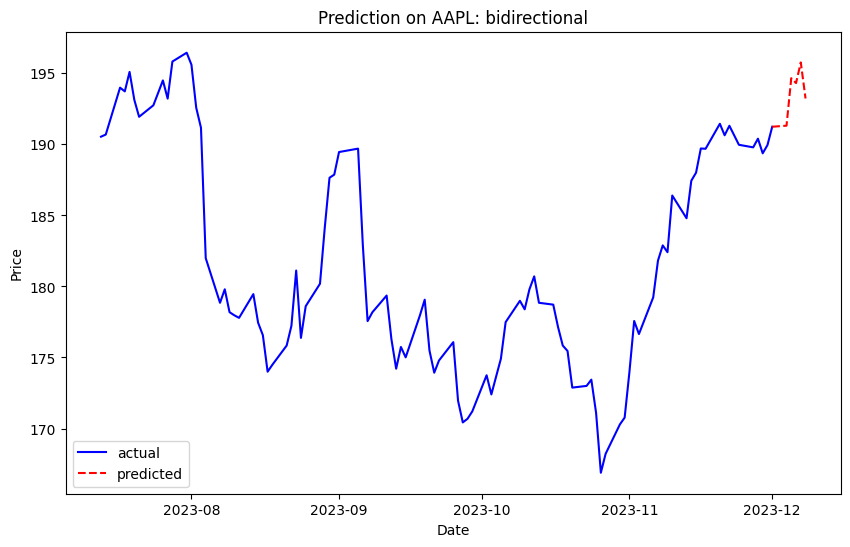

In [65]:
plot_price_with_prediction(predicted_table, symbol=stock_price.symbol, model_name='bidirectional')

We might want to test our model on other stock symbols. Let's test it on Meta Platforms Inc (META):

In [66]:
# define a StockPrice object for META stock
stock_price = StockPrice(
    symbol='META', 
    n_days_backward=100, 
    n_days_forward=5, 
    batch_size=64
)

In [67]:
# split the dataset by the same ratios
train_set, validation_set, test_set = stock_price.generate(
    drop_outliers=True, 
    split_ratios=(0.8, 0.1, 0.1)
)

In [68]:
# fit the baseline model on META stock
naive = NaiveModel()
naive_history = naive.fit(
    train_set=train_set,
    validation_set=validation_set,
    max_epochs=1,
    learning_rate=1e-3,
)

In [69]:
# evaluate the naive model on `test_set` to get the baseline performance:
baseline_loss, baseline_mae = naive.evaluate(test_set=test_set)

3/3 [==============================] - 0s 1ms/step - loss: 0.0013 - mean_absolute_error: 0.0207


In [70]:
print(baseline_loss, baseline_mae)

0.0012999254977330565 0.02072206512093544


In [71]:
# fit my Bidirectional model on META data
bidirectional = Bidirectional()
bidirectional_history = bidirectional.fit(
    train_set=train_set,
    validation_set=validation_set,
    max_epochs=256,
    learning_rate=1e-3,
)

Epoch 10:
loss                     : 0.000564817
mean_absolute_error      : 0.016248077
val_loss                 : 0.001243838
val_mean_absolute_error  : 0.022219917
--------------------
Epoch 20:
loss                     : 0.000439799
mean_absolute_error      : 0.014221330
val_loss                 : 0.001062914
val_mean_absolute_error  : 0.019823527
--------------------
Epoch 30:
loss                     : 0.000393517
mean_absolute_error      : 0.013314025
val_loss                 : 0.001009522
val_mean_absolute_error  : 0.018770300
--------------------
Epoch 40:
loss                     : 0.000337713
mean_absolute_error      : 0.011920332
val_loss                 : 0.000900426
val_mean_absolute_error  : 0.016260544
--------------------
Epoch 50:
loss                     : 0.000279638
mean_absolute_error      : 0.010362800
val_loss                 : 0.000798770
val_mean_absolute_error  : 0.014481266
--------------------
Epoch 60:
loss                     : 0.000237508
mean_absolute_er

In [72]:
# evaluate the Bidirectional model against the baseline's performance
bidirectional_loss, bidirectional_mae = bidirectional.evaluate(test_set=test_set)
print(f'Bidirectional outperforms the baseline model: {bidirectional_mae < baseline_mae}')

3/3 [==============================] - 0s 6ms/step - loss: 7.4886e-04 - mean_absolute_error: 0.0079
Bidirectional outperforms the baseline model: True


The Bidirectional model far outperformed the baseline!

Let's make the prediction:

In [73]:
predicted_table = bidirectional.predict(stock_price.last_sample)
predicted_table.tail(10)

1/1 [==============================] - 0s 260ms/step


,date,type,price
95,2023-11-27,actual,334.700000
96,2023-11-28,actual,338.990000
97,2023-11-29,actual,332.200000
98,2023-11-30,actual,327.150000
99,2023-12-01,actual,324.820000
100,2023-12-04,predicted,317.669444
101,2023-12-05,predicted,319.146379
102,2023-12-06,predicted,319.385036
103,2023-12-07,predicted,323.736742
104,2023-12-08,predicted,308.099901


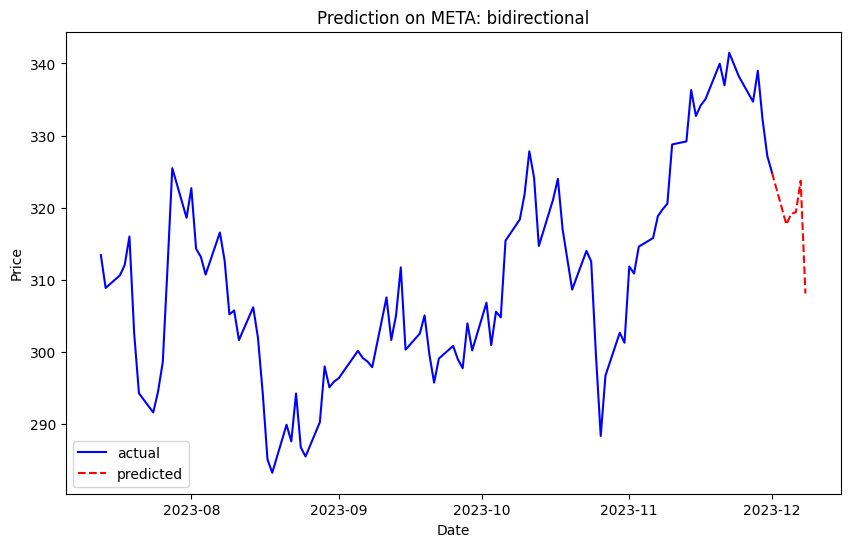

In [74]:
plot_price_with_prediction(predicted_table, symbol=stock_price.symbol, model_name='bidirectional')

## Conclusion

#### <b>The types of models we chose and their performance:</b>

In this assignments, I have chosen to explore 5 sets of neural network models:

1. Multilayer Perceptron (MLP)

2. 1-D Convolutional Neural Network (Conv1D)

3. Long Short Term Memory (LSTM)

4. Gated Recurrent Unit (GRU)

5. Bidirectional (LSTM/GRU)

MLP models were used under the assumption that temporal information is not significant in analyzing stock prices. This over-simplified approach was proven to be ineffective in stock price prediction. The results of MLP models with various configurations did not surpass the simple baseline model.

The other 4 sets of models are particularly well suited in the context of time-series. Conv1D models are considered the most lightweight compared to LSTM, GRU and, Bidirectional. It was employed with the expectation that the local pattern it learns from the stock prices might help in predicting future price values. However, Conv1D architectures alone were not able to outperform the baseline.

LSTM and GRU models are known to be very powerful. I tried these models with a lot of passion since it can capture dependencies of data values across very long time frames. But they failed to improve the performance maybe because processing the information only in one direction is not enough in understanding stock prices. 

Bidirectional models, are those require the highest computational expense, surprisingly worked really well. My bidirectional model of one LSTM layer going forward and one GRU going backward is chosen as the recommended model in predicting stock prices. For AAPL stocks, it gave an MAE of 0.44% on the unseen data for 5 predictions ahead in the future, which is equivalent to only 0.4% / 5 = 0.08% error per day. And for META stocks, it gave an MAE of 0.79%, which is 0.79% / 5 = 0.158% error per day. This is much more than we expected. 


#### <b>Feature selection and feature engineering</b>

In this project, I only used the easily obtainable stock price data, including Open, High, Low, Close Price, and the Traing Volume. These data fields are all available for most of the stocks trading in the US market, and we can easily access the historical values since the stock's first trading date. I used to think about getting data from the financial statements of the companies, but this will definitely introduce a lot of work on data gathering.

Stock prices and volumes are not fed directly into my model. My preliminary EDA showed that these raw data are extremely skewed, potentially making my models very struggle to converge. I have engineered them to log returns (for prices) and log rate of change (for volumes). These engineered features are very bell-shaped and center around 0, which is ideal for training neural networks. 

Artificial price shifts due to stock splits, reverse stock plits, and dividens are also treated as extreme values and removed from the data bofore feeding into the models. These shifts do not reflect changes in trading patterns. On the stock market, investors (who might be among the users of this model) do not gain or incur any net gain/loss due to these shifts. If a stock is splitted by a 2:1 ratio, each of their stocks will become 2 but the price will be adjusted downward by 50%, meaning zero net effect. The same applies for dividends.


#### <b>Model Evaluation</b>

All of our models were trained using the mean squared error (MSE) but evaluated by mean absolute error (MAE). While MSE is continuous and differentiable at every points, MAE is a more intuitive metric that directly tells us how far our results depart from the true values. 


#### <b>What can be done next?</b>

If I have more time, I will run the models on more stocks to confirm my findings. Also, indicators in technical analysis (Exponential Moving Average, Moving Average Convergence Divergence, Relative Strength Index, etc.) could be done to power my feature engineering. By incorporating these indicators, I could enrich the feature space and basically give more useful information to the models. This seems a very promising idea to improve the performance.

---